# Notebook utilised for processing results of CEC22 Manuscrip 2476
Title: **A Transfer Learning Hyper-heuristic Approach for Automatic Tailoring of Unfolded Population-based Metaheuristics**
Authors: Jorge M. Cruz-Duarte, Ivan Amaya, José Carlos Ortiz-Bayliss, and Nelishia Pillay

Load some packages and set some parameters for plotting and showing things


In [48]:
# Processing parameters
is_saving = False  # Please, check if you want to save files
saving_format = 'png'

In [49]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [50]:
# Load data
import tools as tl
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import rankdata
from mpl_toolkits.mplot3d import Axes3D
import os
import seaborn as sns
import benchmark_func as bf

# Basic collection and results for comparison:
basic_collection_file = './collections/basicmetaheuristics.txt'
basic_results_file = './data_files/basic-metaheuristics-data_v2.json'

# Heuristic collection used in the experiments:
collection_file = './collections/default.txt'

# Datafiles from the weight matrix for comparison purposes
datafile_names_uMHs = [
    "unfolded_hhs_pop30",
    "unfolded_hhs_pop50",
    "unfolded_hhs_pop100"
]

# Results from the first experiment:
datafile_names_exp1 = [
    "transfer_learning_dynamic_pop30_exp1",
    "transfer_learning_dynamic_pop50_exp1",
    "transfer_learning_dynamic_pop100_exp1",
    "transfer_learning_static_pop30_exp1",
    "transfer_learning_static_pop50_exp1",
    "transfer_learning_static_pop100_exp1",
]

# Output folder for the figures and results
image_folder_name = './data_files/exp_figures/'
datafolder_name = "./data_files/exp_output/"

# Some lists with useful information
chosen_categories = ['Differentiable', 'Unimodal']
short_cat = ['Diff.', 'Unimod.']

chosen_categories_inv = ['Non-differentiable', 'Multimodal']
tac_trohs = ['Non-Diff.', 'Multimod.']

case_label = 'DU'

def bin2cat(bin_str):
    """
    This function converts binary-based category into string-based one
    :param bin_str: Binary string category
    :return: Human readable string category
    """
    return " and ".join([short_cat[ichar] if (char == '1') else tac_trohs[ichar]
                         for (ichar, char) in enumerate(str(bin_str))])

# Use them to get categories
cat_order = [bin2cat(x) for x in ['11', '10', '01', '00']]

# Use if you need to disregard certain problems
problems_to_disregard = []

# Special adjustments for the plots
sns.set(context="paper", font_scale=1, palette="colorblind", style="ticks",
        rc={'text.usetex': True, 'font.family': 'serif', 'font.size': 24,
            "xtick.major.top": False, "ytick.major.right": False})
plt.rcParams.update({'font.size': 24, 'text.usetex': True, 'font.family': 'serif'})

# Read operators and find their alias
with open(collection_file, 'r') as operators_file:
    encoded_heuristic_space = [eval(line.rstrip('\n')) for line in operators_file]

# Search operator (perturbator and selector) aliases
perturbator_alias = {
    'random_search': 'RS',
    'central_force_dynamic': 'CF',
    'differential_mutation': 'DM',
    'firefly_dynamic': 'FD',
    'genetic_crossover': 'GC',
    'genetic_mutation': 'GM',
    'gravitational_search': 'GS',
    'random_flight': 'RF',
    'local_random_walk': 'RW',
    'random_sample': 'RX',
    'spiral_dynamic': 'SD',
    'swarm_dynamic': 'PS'}

selector_alias = {
    'greedy': 'g',
    'all': 'd',
    'metropolis': 'm',
    'probabilistic': 'p'}

# Pre-process operator families
operator_families = {y: i for i, y in enumerate(sorted([x for x in perturbator_alias.values()]))}

# Pre-build the alias list
heuristic_space = [perturbator_alias[x[0]] + selector_alias[x[2]] for x in encoded_heuristic_space]

# Find repeated elements
for heuristic in heuristic_space:
    concurrences = tl.listfind(heuristic_space, heuristic)
    if len(concurrences) > 1:
        for count, idx in enumerate(concurrences):
            heuristic_space[idx] += f'{count + 1}'

# Read basic metaheuristics
with open(basic_collection_file, 'r') as operators_file:
    basic_mhs_collection = [eval(line.rstrip('\n')) for line in operators_file]

# Read basic metaheuristics cardinality
basic_mhs_cadinality = [1 if isinstance(x, tuple) else len(x) for x in basic_mhs_collection]

# Load data from basic metaheuristics
basic_mhs_data = tl.read_json(basic_results_file)

# Read (of create if so) a folder for storing images
if not os.path.isdir(image_folder_name):
    os.mkdir(image_folder_name)

# Define the performance function
def get_performance(y):
    """
    Function to calculate the performance values from a fitness register
    :param y: Array with fitness values
    :return: Performance value = (median + interquartile_range)(fitness_values)
    """
    return np.median(y) + stats.iqr(y)

In [51]:
def process_basic_mhs():
    """
    This function only reads the dataset from basic metaheuristics and transforms it into a `pandas.DataFrame`
    """
    temp_long_dimensions = basic_mhs_data['dimensions']

    # Call the problem categories
    problem_features = bf.list_functions(fts=chosen_categories)

    # Create a data frame
    data_table = pd.DataFrame({
        'Method': ['Basic'] * len(temp_long_dimensions),
        'Pop': [30] * len(temp_long_dimensions),
        'Dim': [x for x in basic_mhs_data['dimensions']],
        'Problem': basic_mhs_data['problem'],
        'Cat': [problem_features[x]['Code'] for x in basic_mhs_data['problem']],
        'uMH': [x['operator_id'][np.argmin(x['performance'])] for x in basic_mhs_data['results']],
        'Performance': [get_performance(x['performance']) for x in basic_mhs_data['results']]
    })

    return data_table.sort_values(by=['Pop', 'Cat', 'Problem', 'Dim'], ignore_index=True)

# Use the processing routine
data_table_basic = process_basic_mhs()

# Show the data
data_table_basic

,Method,Pop,Dim,Problem,Cat,uMH,Performance
0,Basic,30,2,Alpine1,00,60,9.889813e-02
1,Basic,30,5,Alpine1,00,63,5.267582e+00
2,Basic,30,10,Alpine1,00,63,1.611200e+01
3,Basic,30,20,Alpine1,00,61,4.842638e+01
4,Basic,30,30,Alpine1,00,63,8.255213e+01
...,...,...,...,...,...,...,...
744,Basic,30,10,Zakharov,11,63,2.192610e+02
745,Basic,30,20,Zakharov,11,9,9.065244e+02
746,Basic,30,30,Zakharov,11,9,1.634667e+03
747,Basic,30,40,Zakharov,11,9,3.585086e+04


## 0. Define some tools to use
### Adjusting function
We employed the expression $\hat{x} = \text{sign}(x) \log{(|x|+1)}$ to adjust the fitness values from extremely high values (in magnitude) to a short range.

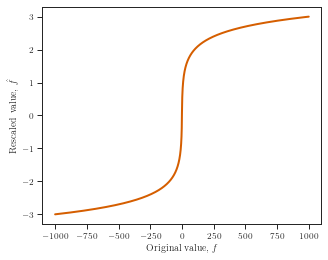

In [52]:
# Define the rescaling function
def rescaling_function(values):
    # This function rescales any fitness value to a magnitude-based representation for enhancing its comparison against other values
    return (-1 if values < 0 else 1) * np.log10(np.abs(values) + 1)

# Show how this function works
fig = plt.figure(figsize=(5, 4))
x_values = np.linspace(-1e3, 1e3, 5000)
plt.plot(x_values, np.vectorize(rescaling_function)(x_values), c='r', linewidth=2)
plt.xlabel(r"Original value, $f$")
plt.ylabel(r"Rescaled value, $\hat{f}$")
plt.show()

### Reading the base dataset for comparisons
In this part, we only read and process the base dataset for comparison purposes

In [53]:
# Define the method for processing data from unfolding metaheuristics
def process_data(dataframe_filename):
    # Read the data file and assign the variables
    data_frame = tl.read_json(f'data_files/{dataframe_filename}.json')

    # Read all the dimensions (repeated)
    temp_long_dimensions = data_frame['dimensions']

    # Call the problem categories
    problem_features = bf.list_functions(fts=chosen_categories)

    # Create a data frame
    data_table = pd.DataFrame({
        'Method': ['Base'] * len(temp_long_dimensions),
        'Pop': [int(dataframe_filename.split('pop')[-1])] * len(temp_long_dimensions),
        'Dim': [x for x in data_frame['dimensions']],
        'Problem': data_frame['problem'],
        'Cat': [problem_features[x]['Code'] for x in data_frame['problem']],
        'uMH': [x['encoded_solution'][-1] for x in data_frame['results']],
        'Performance': [x['performance'][-1] for x in data_frame['results']],
        'BestFitness': [[y[-1] for y in x['hist_fitness']] for x in data_frame['results']],
        'PerformanceEvolution': [x['performance'] for x in data_frame['results']]
    })

    # Compute the metric using the rescaling function
    data_table['Metric'] = data_table['BestFitness'].apply(
            lambda x: [rescaling_function(y) for y in x])

    return data_table

# Create an empty list and process all the base dataset files
data_table_exp0_list = list()
for datafile_name in datafile_names_uMHs:
    data_table_exp0_list.append(process_data(datafile_name))

# Store this information in a dataframe and show it
data_table_exp0 = pd.concat(data_table_exp0_list, ignore_index=True)
data_table_exp0

,Method,Pop,Dim,Problem,Cat,uMH,Performance,BestFitness,PerformanceEvolution,Metric
0,Base,30,2,Csendes,00,"[187, 15, 50, 132, 111, 143, 23, 78, 194, 42, ...",0.000000,"[0.0, 0.0, 0.0, 0.0, 2.8537589955370346e-20, 0...","[3.4535108778470087e-16, 9.94780148253074e-17,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Base,30,2,CarromTable,00,"[96, 63, 54, 65, 64, 129, 192, 155, 56, 145, 1...",-24.156813,"[-24.15681551308903, -24.156815198897103, -24....","[-24.13786046899609, -24.153516755226196, -24....","[-1.4006556648883506, -1.4006556594643007, -1...."
2,Base,30,2,Ackley1,10,"[37, 112, 39, 169, 64, 45, 47, 5, 170, 77, 48,...",0.000000,"[0.0, 0.058904065010143114, 0.0, 1.45224526223...","[0.11913695576918837, 0.1074238418548612, 0.07...","[0.0, 0.024856615514466728, 0.0, 0.38956390414..."
3,Base,30,2,Ellipsoid,11,"[109, 0, 172, 179, 52, 138, 80, 85, 73, 163, 3...",0.000009,"[7.241395303025622e-08, 8.135541043164586e-06,...","[0.0017907108021266843, 0.0016771474166918337,...","[3.144897908640482e-08, 3.5332062100475014e-06..."
4,Base,30,2,Bohachevsky,10,"[86, 29, 172, 160, 160, 105, 52, 73, 63, 15, 6...",0.000010,"[6.143139894554395e-07, 2.6283801757287506e-07...","[0.026824167983468816, 0.009798601016419911, 0...","[2.6679309382911324e-07, 1.1414908566493054e-0..."
...,...,...,...,...,...,...,...,...,...,...
1279,Base,100,50,XinSheYang3,11,"[142, 177, 73, 188, 91, 87, 11, 29, 102, 142, ...",0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1280,Base,100,50,YaoLiu09,10,"[115, 176, 82, 34, 106, 144, 3, 1, 58, 56, 44,...",352.048079,"[333.63708729722714, 346.479536861292, 305.711...","[529.9101065959779, 516.6676247795713, 497.802...","[2.5245740714618674, 2.5409292339911755, 2.486..."
1281,Base,100,50,ZeroSum,00,"[126, 3, 150, 101, 137, 111, 11, 129, 54, 194,...",3.004275,"[1.8245789433375443, 2.3937620926785312, 2.704...","[13.751717757179504, 12.719202573443802, 12.51...","[0.45095371721246574, 0.530681394417033, 0.568..."
1282,Base,100,50,XinSheYang1,00,"[182, 75, 33, 151, 2, 95, 33, 157, 45, 129, 11...",4111.153230,"[1556.0525205005727, 542.0028688461191, 197.06...","[269699711694641.8, 4111.153229638988]","[3.1923032618801903, 2.7348021241021945, 2.296..."


### Prepare methods to read and process the resulting datasets
In this case, we proceed to prepare methods to read and process the datasets from the resulting experiments

In [54]:
# Prepare the method for reading dataframes and building the datatable with pandas
def get_datatable(dataframe_filename):
    # Generate key for the output dictionary
    key, pop, kind = dataframe_filename.split('_')[2:]

    # Just for testing
    full_datafile_name = datafolder_name + dataframe_filename + '.json'

    data_frame = tl.read_json(full_datafile_name)

    # Read dimensions and problems
    long_dimensions = data_frame['dimensions']
    long_problems = data_frame['problem']

    dimensions = sorted(list(set(long_dimensions)))
    problems = sorted(list(set(long_problems)))

    num_prob = len(problems)
    num_dime = len(dimensions)

    # Call the problem categories
    problem_features = bf.list_functions(fts=chosen_categories)

    # Check if it is `dynamic` or `static`
    if key == 'dynamic':
        # Create a data frame
        data_table = pd.DataFrame({
            'Method': ['Dynamic'] * len(long_dimensions),
            'Pop': [int(pop[3:])] * len(long_dimensions),
            'Dim': [x for x in data_frame['dimensions']],
            'Problem': data_frame['problem'],
            'Cat': [problem_features[x]['Code'] for x in data_frame['problem']],
            'BestFitness': [[y[-1] for y in x['details']['fitness_per_rep']] for x in data_frame['results']],
            'Sequences': [x['details']['sequence_per_rep'] for x in data_frame['results']],
            'FitnessEvolution': [x['details']['fitness_per_rep'] for x in data_frame['results']],
        })\
            .sort_values(by=['Pop', 'Cat', 'Problem', 'Dim'], ignore_index=True)

        # data_table['Metric'] = data_table['BestFitness'].apply(rescaling_function)
        data_table['Metric'] = data_table['BestFitness'].apply(
            lambda x: [rescaling_function(y) for y in x])

        weight_table = pd.DataFrame({
            'Pop': [int(pop[3:])] * len(long_dimensions),
            'Dim': [str(x) for x in data_frame['dimensions']],
            'Problem': data_frame['problem'],
            'Cat': [problem_features[x]['Code'] for x in data_frame['problem']],
            'Weights': [x['details']['weight_matrix'] for x in data_frame['results']],
        })
    else:  # 'static'
        # Create a data frame
        data_table = pd.DataFrame({
            'Method': ['Static'] * len(long_dimensions),
            'Pop': [int(pop[3:])] * len(long_dimensions),
            'Dim': [x for x in data_frame['dimensions']],
            'Problem': data_frame['problem'],
            'Cat': [problem_features[x]['Code'] for x in data_frame['problem']],
            'Performance': [x['performance'][-1] for x in data_frame['results']],
            'BestFitness': [[y[-1] for y in x['hist_fitness']] for x in data_frame['results']],
            'Sequences': [x['encoded_solution'][-1] for x in data_frame['results']],
            'PerformanceEvolution': [x['performance'][::2] for x in data_frame['results']],
        }).sort_values(by=['Pop', 'Cat', 'Problem', 'Dim'], ignore_index=True)

        data_table['Metric'] = data_table['BestFitness'].apply(
            lambda x: [rescaling_function(y) for y in x])

        weight_table = None

    return key + pop[3:] + kind, data_table, weight_table


## 1. Adjusted best-fitness values
This is a glance for the selected problems and their adjusted best-fitness values. In this case, we plot the fitness values (adjusted) using the expression $\hat{x} = \text{sign}(x) \log{(|x|+1)}$, and consider all the two groups of datasets from experimental results

In [55]:
# Prepare methods for getting data from the datasets
def get_experiment_data(datafile_names_exp):
    """
    This method applies the above defined method to process datafiles for a given experiment dataset.
    :param datafile_names_exp: list, list of datafile names related to experiment datasets
    :returns: three lists: `data_info_exp_list` with the information related to experiments
                           `data_table_exp_list` with the datasets
                           `weight_table_exp_list` with the wight matrices

    """
    data_info_exp_list = list()
    data_table_exp_list = list()
    weight_table_exp_list = list()

    for datafile_name in datafile_names_exp:
        data_info_exp, data_table_exp, weight_table_exp = get_datatable(datafile_name)

        data_info_exp_list.append(data_info_exp)
        data_table_exp_list.append(data_table_exp)
        weight_table_exp_list.append(weight_table_exp)

    return data_info_exp_list, data_table_exp_list, weight_table_exp_list


def plot_metrics(data_info_list, data_table_list):
    """
    This method is used for plotting metrics in an early state of analysis
    :param data_info_list: list, information related to experiments
    :param data_table_list: list, datasets
    """

    for die2, dte2 in zip(data_info_list, data_table_list):
        facet_out1 = sns.catplot(
            data=dte2[['Cat', 'Problem', 'Dim', 'Metric']].explode(
                'Metric', ignore_index=True),
            col='Problem', y='Metric', x='Dim', col_wrap=8, kind='box', orient='v',
            sharey=False, height=2, facet_kws=dict(despine=False, palette='dark'))

        facet_out1.set_titles(col_template="{col_name}")

        if is_saving:
            plt.savefig(image_folder_name + 'boxplots-{}.'.format(die2) + saving_format,
                       format=saving_format, dpi=333, transparent=True)

        plt.show()

### Process and plot metrics for the first experiment
In this, we use the above defined methods for showing an overview of results

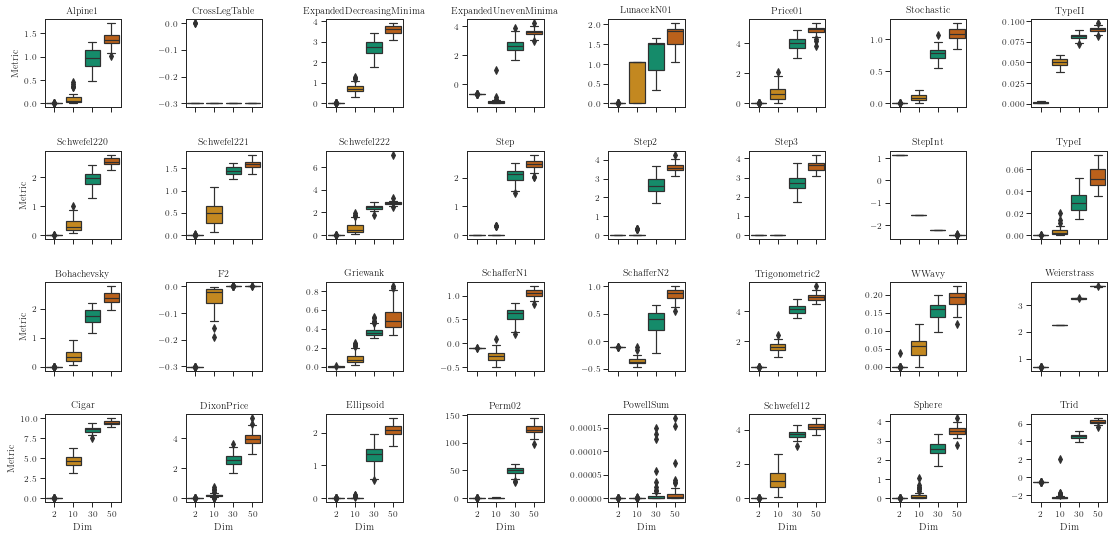

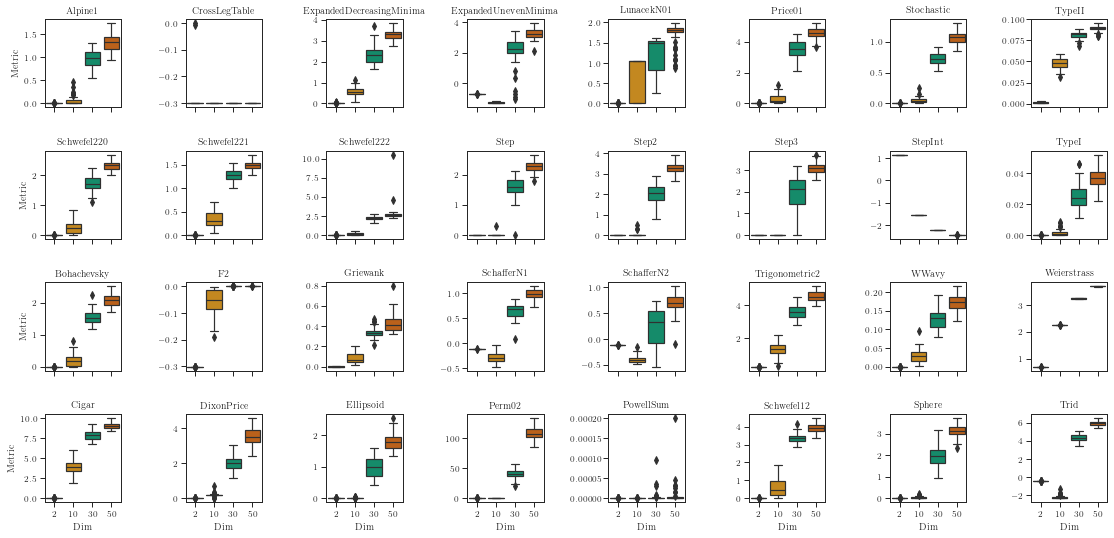

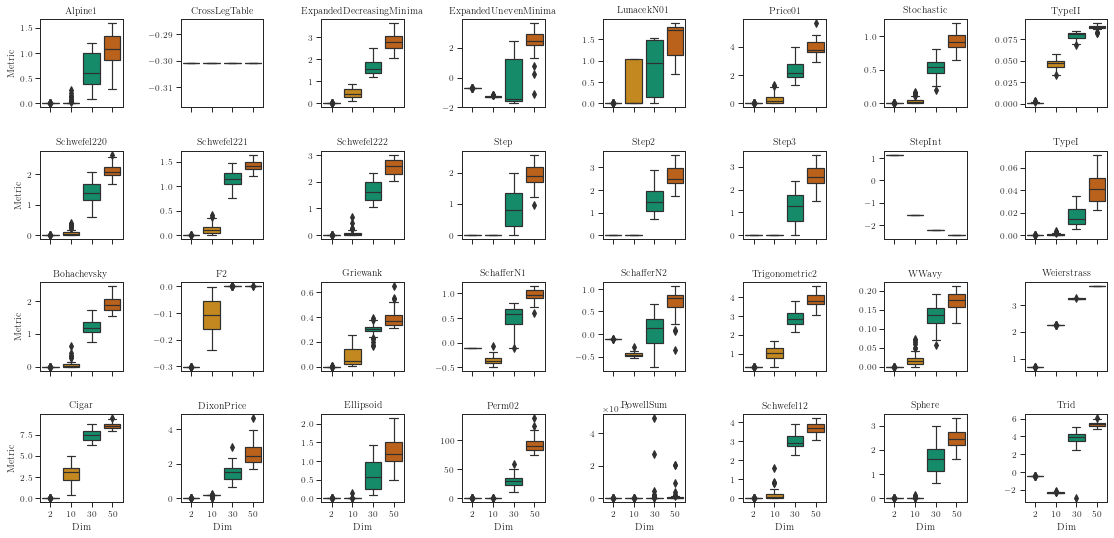

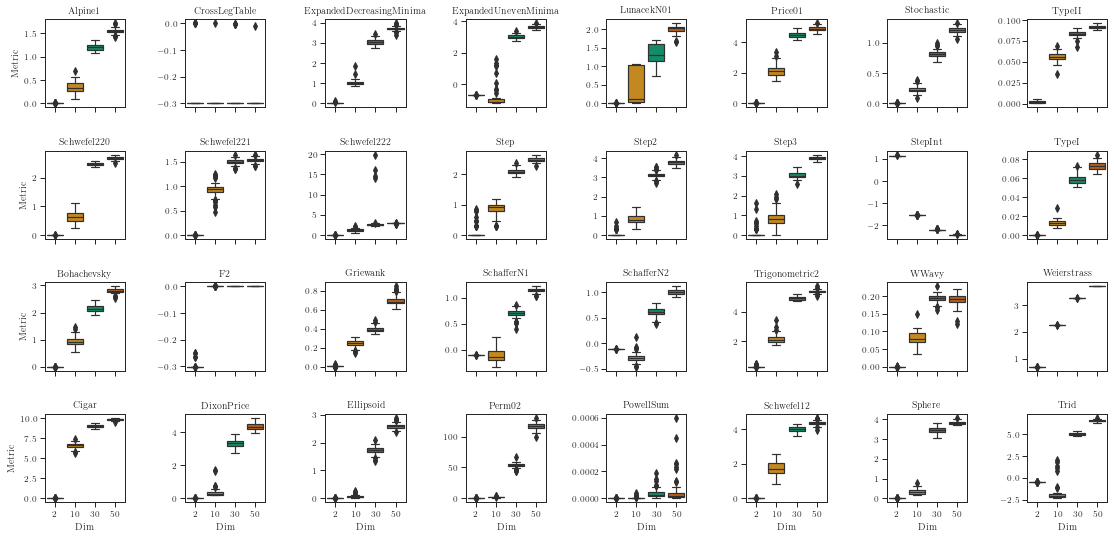

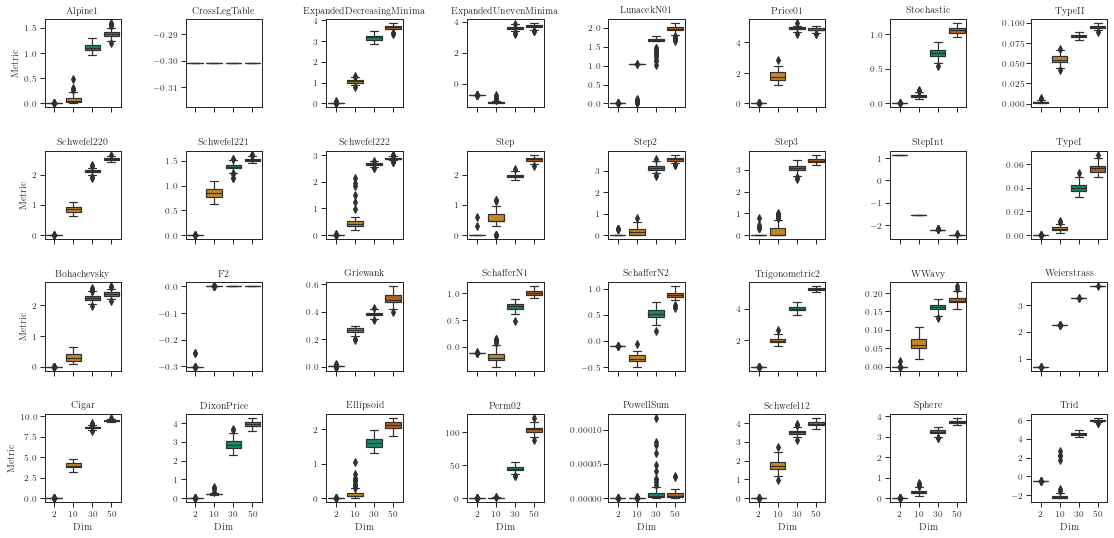

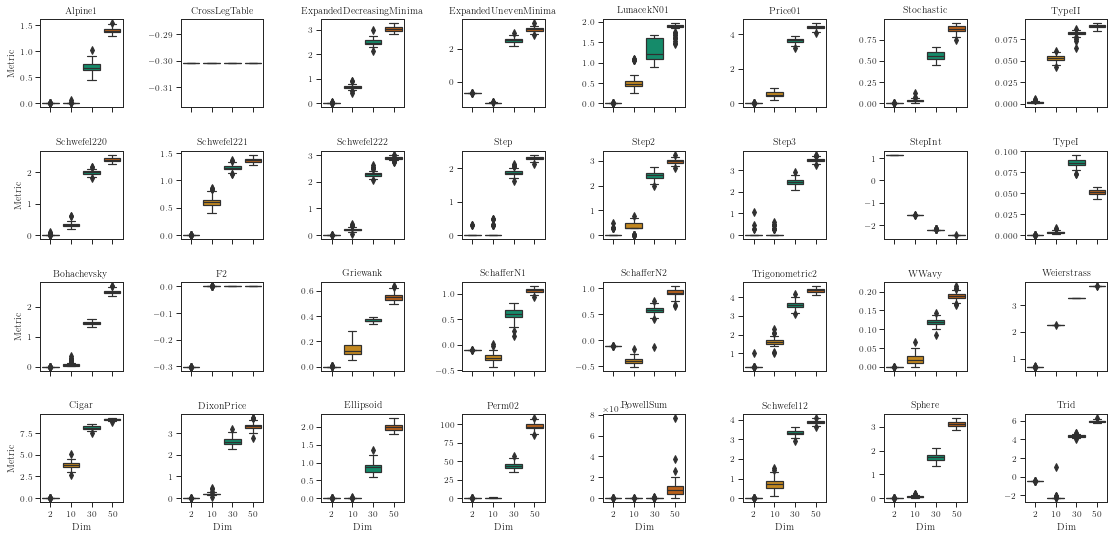

In [56]:
data_info_exp1_list, data_table_exp1_list, weight_table1_exp_list = get_experiment_data(datafile_names_exp1)
plot_metrics(data_info_exp1_list, data_table_exp1_list)

## 2. Data reported in the manuscript
In this section, we organised those plot that were included in the manuscript.
The comparison between the experiment 1 and the experiments 0 and basic metaheuristics, these two sets comprise the same problems, populations and dimensions.

In [57]:
# Merge data_tables from experiment 1
data_table_exp1 = pd.concat(data_table_exp1_list, ignore_index=True)
data_table_exp1['Problem'].unique()

# Read the problems considered for all the experiments (1 & 2)
problems_to_consider = data_table_exp1['Problem'].unique().tolist()

# Filter the data table for the experiment 0 using the problems from data_table for experiment 1
data_table_exp0['Problem'].unique()

# Filter to only use the problems
data_table_exp0 = data_table_exp0[data_table_exp0['Problem'].isin(problems_to_consider)]

# Show table from experiments 0
data_table_exp0

,Method,Pop,Dim,Problem,Cat,uMH,Performance,BestFitness,PerformanceEvolution,Metric
3,Base,30,2,Ellipsoid,11,"[109, 0, 172, 179, 52, 138, 80, 85, 73, 163, 3...",8.807482e-06,"[7.241395303025622e-08, 8.135541043164586e-06,...","[0.0017907108021266843, 0.0016771474166918337,...","[3.144897908640482e-08, 3.5332062100475014e-06..."
4,Base,30,2,Bohachevsky,10,"[86, 29, 172, 160, 160, 105, 52, 73, 63, 15, 6...",1.003872e-05,"[6.143139894554395e-07, 2.6283801757287506e-07...","[0.026824167983468816, 0.009798601016419911, 0...","[2.6679309382911324e-07, 1.1414908566493054e-0..."
6,Base,30,2,DixonPrice,11,"[167, 58, 179, 168, 118, 180, 40, 93, 86, 149,...",4.642558e-05,"[9.623533045783356e-05, 4.2358863528643173e-05...","[0.0006881544771762952, 0.0002393374403952969,...","[4.179246205854887e-05, 1.839583107964212e-05,..."
7,Base,30,2,CrossLegTable,00,"[76, 178, 159, 80, 82, 203, 63, 66, 26, 111, 7...",-1.000000e+00,"[-1.0, -0.00025803376668201335, -1.0, -1.0, -0...","[-0.00014667023497376384, -0.00015989322350280...","[-0.3010299956639812, -0.00011204818552863077,..."
10,Base,30,2,ExpandedDecreasingMinima,00,"[67, 171, 70, 186, 81, 126, 28, 113, 171, 119,...",8.191654e-02,"[0.06925946889235624, 0.0839174578732318, 0.00...","[1.892756737342614, 0.2977767103939751, 0.2517...","[0.029083104867115392, 0.034996211210604, 9.15..."
...,...,...,...,...,...,...,...,...,...,...
1271,Base,100,50,TypeII,00,"[156, 111, 69, 30, 108, 172, 154, 46, 68, 177,...",2.440498e-01,"[0.23490990354335378, 0.24244113346630372, 0.2...","[0.25601265000648193, 0.24587473107294733, 0.2...","[0.09163527352986356, 0.09427582113463755, 0.0..."
1273,Base,100,50,Trid,11,"[61, 160, 31, 8, 3, 106, 40, 116, 197, 21, 36,...",3.514433e+06,"[2573801.583513391, 4332937.815525144, 2773709...","[12243302.849481976, 9796348.971073547, 929174...","[6.410575232475597, 6.63678255650093, 6.443061..."
1276,Base,100,50,WWavy,10,"[19, 93, 46, 123, 172, 127, 43, 198, 72, 200, ...",6.066920e-01,"[0.605233442216699, 0.5798709060226617, 0.6168...","[0.7709484778999283, 0.7423562849462182, 0.734...","[0.20553819891807157, 0.19862160145282867, 0.2..."
1278,Base,100,50,Trigonometric2,10,"[116, 114, 98, 79, 41, 105, 34, 127, 49, 151, ...",1.646080e+04,"[14874.512449729025, 16430.50726270529, 11182....","[235954.7258330117, 225216.9515457084, 203054....","[4.172471935762343, 4.2156774031095425, 4.0485..."


In [58]:
# Columns to consider in the concatenation
columns_to_concatenate = ['Method', 'Pop', 'Dim', 'Problem', 'Cat', 'BestFitness']

# Concatenate experiments 0 & 1
dt_comp_exp1 = pd.concat(
    [data_table_exp0[columns_to_concatenate]] +
    [dt[columns_to_concatenate] for dt in data_table_exp1_list],
    ignore_index=True)

# Adjust the performance value to have the same scale
dt_comp_exp1['Metric'] = dt_comp_exp1['BestFitness'].apply(
    lambda x: [rescaling_function(y) for y in x])

# Perform some adjustments to facilitate comparison
dt_comp_exp1['Dim'].unique()
dt_comp_exp1['DU'] = dt_comp_exp1['Cat'].map(bin2cat)
dt_comp_exp1 = dt_comp_exp1.sort_values(by=['Pop', 'Method', 'Dim', 'Cat', 'Problem'], ascending=[1, 1, 1, 0, 1], ignore_index=True)

# Show the resulting table
dt_comp_exp1

,Method,Pop,Dim,Problem,Cat,BestFitness,Metric,DU
0,Base,30,2,Cigar,11,"[0.025761254242735603, 0.05699490426374157, 0....","[0.011046290570663933, 0.024072893593639375, 0...",Diff. and Unimod.
1,Base,30,2,DixonPrice,11,"[9.623533045783356e-05, 4.2358863528643173e-05...","[4.179246205854887e-05, 1.839583107964212e-05,...",Diff. and Unimod.
2,Base,30,2,Ellipsoid,11,"[7.241395303025622e-08, 8.135541043164586e-06,...","[3.144897908640482e-08, 3.5332062100475014e-06...",Diff. and Unimod.
3,Base,30,2,Perm02,11,"[4.094199546644793e-06, 1.373247198743892e-07,...","[1.7780846310382243e-06, 5.963936395078183e-08...",Diff. and Unimod.
4,Base,30,2,PowellSum,11,"[9.107161962215606e-10, 3.2188774206642965e-10...","[3.955190066594746e-10, 1.3979411689738487e-10...",Diff. and Unimod.
...,...,...,...,...,...,...,...,...
1147,Static,100,50,ExpandedUnevenMinima,00,"[1739.933952833668, 673.3584887534126, 1296.67...","[3.240782295262088, 2.8288908287279058, 3.1131...",Non-Diff. and Multimod.
1148,Static,100,50,LunacekN01,00,"[73.28889664507683, 88.39575264873774, 80.7119...","[1.8709239081600681, 1.9513168851825469, 1.912...",Non-Diff. and Multimod.
1149,Static,100,50,Price01,00,"[24619.23233409044, 26712.5212892864, 29451.99...","[4.39129214692744, 4.426731139077521, 4.469129...",Non-Diff. and Multimod.
1150,Static,100,50,Stochastic,00,"[7.619069775764095, 6.457008296541049, 7.71215...","[0.9354603965610886, 0.8725646262796005, 0.940...",Non-Diff. and Multimod.


### Figure 2: Metric strips for all methods using DU, Pop, and Dim
This is a compact representation for analysing metric values via grouping by categories (DU), populaiton (Pop), and dimensionalities (Dim)


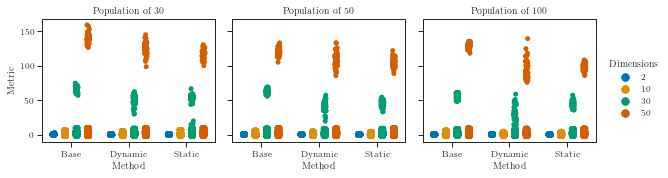

In [59]:
# Marginal plot related to Categories
with sns.color_palette("colorblind"):
    facet_out2 = sns.catplot(
        data=dt_comp_exp1.explode('Metric', ignore_index=True),
        col='Pop', y='Metric', x='Method', hue='Dim', kind='strip', orient='v',
        sharey=True, height=3, aspect=1, facet_kws=dict(despine=False, legend_out=False),
        margin_titles=True, legend=False, dodge=True)
    plt.subplots_adjust(hspace = 0.08, wspace=0.1)
    facet_out2.add_legend(title='Dimensions', bbox_to_anchor=(0.98, 0.5))
    facet_out2.set_titles(col_template="Population of {col_name}")

if is_saving:
    plt.savefig(image_folder_name + 'plot1-Metric-vs-DimPop_Exp1.' + saving_format,
               format=saving_format, dpi=333, transparent=True)

plt.show()

### Figure 3: Metric distribution for all methods using DU, Pop, and Dim.
This is a grid-like representation for analysing metric values via grouping by categories (DU), populaiton (Pop), and dimensionalities (Dim)

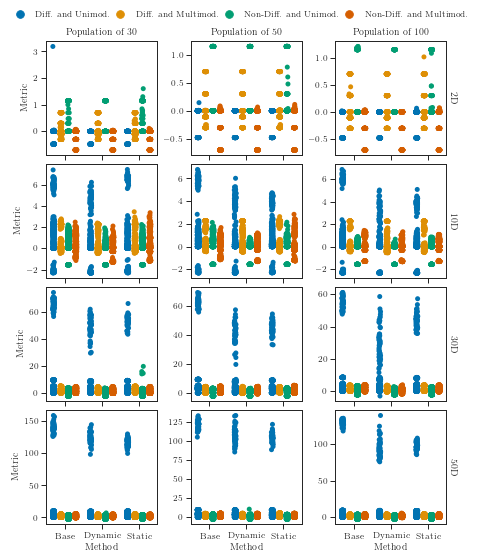

In [60]:
# Marginal plot related to Population
with sns.color_palette("colorblind"):
    facet_out2 = sns.catplot(
        data=dt_comp_exp1.explode('Metric', ignore_index=True),
        col='Pop', row='Dim', y='Metric', x='Method', hue='DU', kind='strip', orient='v',
        sharey=False, height=2, aspect=1.3, margin_titles=True, dodge=True, legend=False,
        facet_kws=dict(despine=False, legend_out=True))

    facet_out2.set_titles(col_template="Population of {col_name}",
                          row_template="{row_name}D")
    plt.subplots_adjust(hspace = 0.08, wspace=0.3)
    facet_out2.add_legend(loc='upper left', ncol=4, columnspacing=0.1,
                          bbox_to_anchor=(0.075, 1))

if is_saving:
    plt.savefig(image_folder_name + 'plot2-Metric-vs-All_Exp1.' + saving_format,
               format=saving_format, dpi=333, transparent=True)

plt.show()

### Table III: Wilcoxon's test for the experiments
In these plots, we show the $p$-value results for the Wilcoxon's test described in the manuscript

In [61]:
# Add some statistics for ranking
new_columns = dict(
    # max_fitness = lambda x: x['BestFitness'].apply(np.max),
    # min_fitness = lambda x: x['BestFitness'].apply(np.min),
    # mean_fitness = lambda x: x['BestFitness'].apply(np.mean),
    # median_fitness = lambda x: x['BestFitness'].apply(np.median),
    perf_alt = lambda x: x['BestFitness'].apply(lambda y: get_performance(y))
)
dt_comp_exp1 = dt_comp_exp1.assign(**new_columns)

# Now do the ranking
columns_to_rank = ['Pop', 'Dim', 'Problem', 'Cat']

In [62]:
# Pick data for carrying out the statistical test
pivoted_table = dt_comp_exp1.pivot_table(
    index=['Pop', 'Dim', 'DU', 'Problem'], columns='Method', values='perf_alt').reset_index()
pivoted_table['BaseDynamic'] = pivoted_table['Dynamic'] - pivoted_table['Base']
pivoted_table['BaseStatic'] = pivoted_table['Static'] - pivoted_table['Base']

# Perform the test
pValue_table1 = pivoted_table.groupby(['Pop', 'Dim'])['BaseDynamic', 'BaseStatic'].agg(
    lambda z: stats.wilcoxon(x=z.values, alternative='less', zero_method='pratt')[-1]
).reset_index()

pValue_table1

# Showing the same info but in LaTeX
# print(
# pValue_table1.to_latex(
#     index=False, bold_rows=True, multirow=True, float_format="{:0.2e}".format)
# )

Method,Pop,Dim,BaseDynamic,BaseStatic
0,30,2,3.902643e-06,0.002689
1,30,10,4.456970e-06,0.037038
2,30,30,6.067037e-07,0.012107
3,30,50,4.831546e-05,0.003256
4,50,2,7.628134e-07,0.000047
5,50,10,2.452007e-05,0.599669
6,50,30,6.065289e-05,0.224383
7,50,50,9.467212e-03,0.024258
8,100,2,2.913588e-04,0.032225
9,100,10,1.305681e-04,0.001643


Analysing methods from a general point of view

### Figure 4: Frequency of methods that rank 1st
In this plot, we show the frequency of those methods that rank first when comparison is made using a given metric

perf_alt


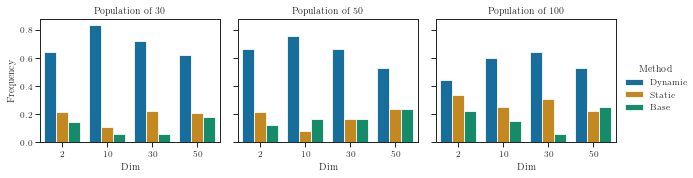

In [63]:
# Plot the corresponding figure for the frequencies of first places and grouping by dimensions and methods
def plot_comparison3_by(metric_column):
    dt_comp_exp1['Rank'] = dt_comp_exp1.groupby(columns_to_rank)[metric_column].rank('dense')
    dtce1_short = dt_comp_exp1.query("Rank == 1.0")
    dtce1_short = dtce1_short.groupby(['Pop', 'Dim'])['Method'].value_counts(normalize=True).rename('Frequency').reset_index()
    with sns.color_palette("colorblind"):
        facet_out1 = sns.catplot(data=dtce1_short,
                    hue='Method', x='Dim', y='Frequency', col='Pop', kind='bar',
                    height=3, aspect=1, ci=True, #fill=False, alpha=0.5, levels=5, linewidths=2,  #cut=1,
                    # warn_singular=False,
                    facet_kws=dict(despine=False)
                    )
    plt.subplots_adjust(hspace = 0.08, wspace=0.1)
    facet_out1.set_titles(col_template="Population of {col_name}")

    if is_saving:
        plt.savefig(image_folder_name + 'plot4-Rank-vs-DimPop_Exp1.' + saving_format,
                   format=saving_format, dpi=333, transparent=True)
    plt.show()

for col in new_columns.keys():
    print(col)
    plot_comparison3_by(col)

## 4. Additional figures
The figures and tables reported here just serve to analyse the resulting data. This information was not included due to space limitations.

### Graphical representation of Table III: Wilcoxon's test
In this figure, we show the graphical visualization of $p$-values

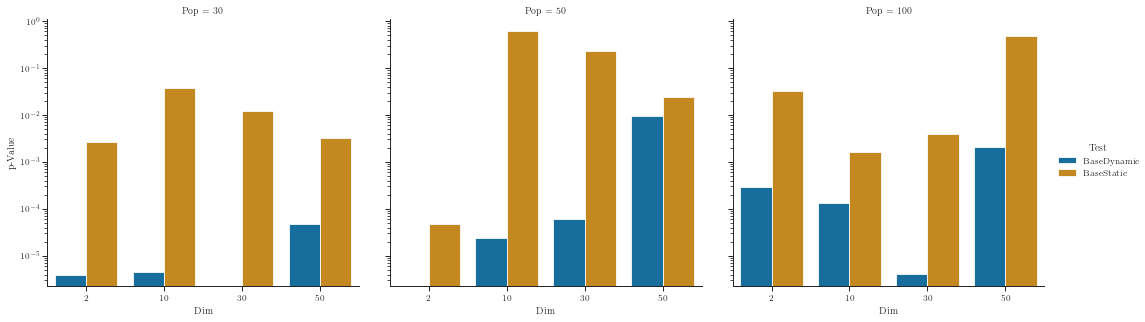

In [64]:
# Show the resulting p-values
sns.catplot(
    data=pValue_table1.melt(
        id_vars=['Pop', 'Dim'], value_vars=['BaseDynamic', 'BaseStatic'],
        var_name='Test', value_name='p-Value'
    ), x='Dim', col='Pop', y='p-Value', hue='Test', kind='bar', log=True
)
plt.show()

### Extended Figure 4: Frequency of methods that rank 1st
In this case, we considered all the grouping ways to represent these frequencies: Population, Methods, Dimensions, and Categories

perf_alt


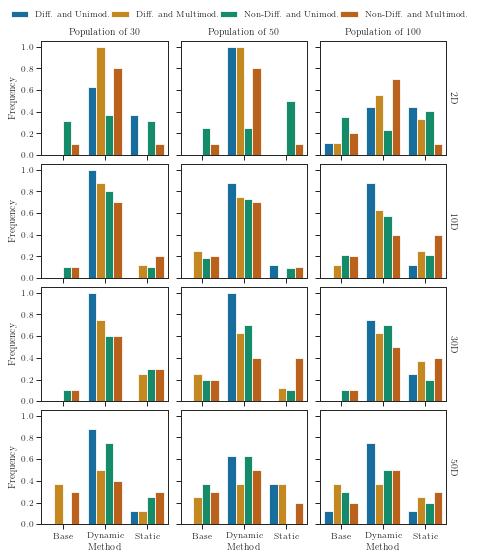

In [65]:
def plot_comparison11_by(metric_column):
    dt_comp_exp1['Rank'] = dt_comp_exp1.groupby(columns_to_rank)[metric_column].rank('dense')
    dtce1_short = dt_comp_exp1.query("Rank == 1.0")
    dtce1_short = dtce1_short.groupby(['Pop', 'Dim', 'DU'])['Method']\
        .value_counts(normalize=True)\
        .rename('Frequency')\
        .reset_index()
    dtce1_short = dtce1_short.sort_values(
        by=['Pop', 'Method', 'Dim', 'DU'],
        ascending=[1, 1, 1, 1],
        ignore_index=True)

    with sns.color_palette("colorblind"):
        facet_out1 = sns.catplot(data=dtce1_short,
                    hue='DU', x='Method', y='Frequency', row='Dim', col='Pop', kind='bar',
                    height=2, aspect=1.3, ci=True, hue_order=cat_order,
                    facet_kws=dict(despine=False, legend_out=True), margin_titles=True,
                    legend=False)

    facet_out1.set_titles(col_template="Population of {col_name}",
                          row_template="{row_name}D")
    plt.subplots_adjust(hspace = 0.08, wspace=0.1)
    facet_out1.add_legend(loc='upper left', ncol=4, columnspacing=0.1,
                          bbox_to_anchor=(0.075, 1))
    if is_saving:
        plt.savefig(image_folder_name + 'plot3-Rank-vs-All_Exp1.' + saving_format,
                   format=saving_format, dpi=333, transparent=True)

    plt.show()

# Show the plot using a given metric from the `new_columns` dictionary
for col in new_columns.keys():
    print(col)
    plot_comparison11_by(col)

### Comparison with basic metaheuristics
These results were not included in the manuscript but show quite interesting results about the proposed method when compared against basic metaheuristics (most of them are state-of-the-art methods).

In [66]:
# Load and concatenate dataframes to perform comparisons

# Columns to be concatenated
columns_to_concatenate = ['Method', 'Pop', 'Dim', 'Problem', 'Cat', 'Performance']

# We assign the comparison column
dt_comp_exp1['Performance'] = dt_comp_exp1['perf_alt']

data_table_basic = data_table_basic[data_table_basic['Problem'].isin(problems_to_consider)]
data_table_basic = data_table_basic[data_table_basic['Dim'].isin(
    dt_comp_exp1['Dim'].unique())]
dt_comp_exp1_basic = pd.concat([
    dt_comp_exp1[columns_to_concatenate], data_table_basic[columns_to_concatenate]
])

We only carried out the comparison with populations of 30 agents because of the available dataset of basic metaheuristics

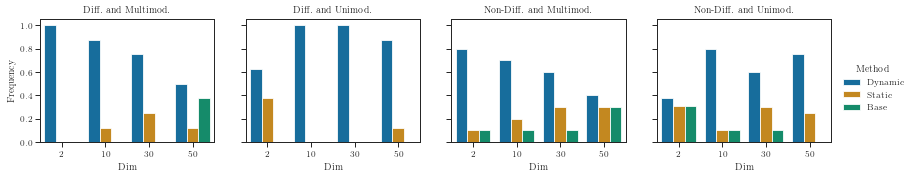

In [67]:
dt_comp_exp1_basic['Rank'] = dt_comp_exp1_basic.groupby(columns_to_rank)['Performance'].rank('dense')
dt_comp_exp1_basic['DU'] = dt_comp_exp1_basic['Cat'].map(bin2cat)
dtce1_short = dt_comp_exp1_basic.query("Pop == 30 & Dim == [2, 10, 30, 50] & Rank == 1.0")
dtce1_short = dtce1_short.groupby(['Dim', 'DU'])['Method'].value_counts(normalize=True).rename('Frequency').reset_index()

with sns.color_palette("colorblind"):
    # g = sns.FacetGrid(dt_comp_exp1.query("Rank == 1.0"), row='Pop', col='Cat')
    # g.map_dataframe(lambda data, color: sns.barplot(x=data['Dim'], y=data['Method']))

    facet_out1 = sns.catplot(data=dtce1_short,
                hue='Method', x='Dim', col='DU', col_wrap=4, y='Frequency', kind='bar',
                height=3, aspect=1, ci=True, #fill=False, alpha=0.5, levels=5, linewidths=2,  #cut=1,
                # warn_singular=False,
                facet_kws=dict(despine=False)
                )

    facet_out1.set_titles(col_template="{col_name}")
if is_saving:
    plt.savefig(image_folder_name + 'plot5-rank_Pop-Dim-Method.' + saving_format,
               format=saving_format, dpi=333, transparent=True)
plt.show()

Wilcoxon's test

Method,Pop,Dim,BasicBase,BasicDynamic,BasicStatic
0,30,2,3.976442e-07,3.976442e-07,3.976442e-07
1,30,10,3.976442e-07,4.375640e-07,3.976442e-07
2,30,30,3.976442e-07,4.375640e-07,3.976442e-07
3,30,50,3.976442e-07,4.375640e-07,3.976442e-07


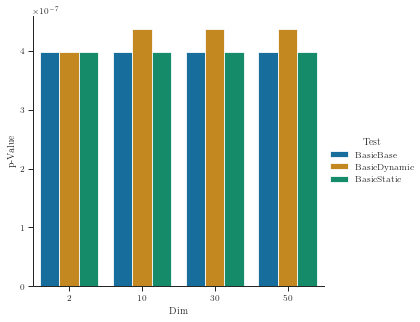

In [68]:
pivoted_table2 = dt_comp_exp1_basic.pivot_table(
    index=['Pop', 'Dim', 'DU', 'Problem'], columns='Method', values='Performance'
).reset_index()
pivoted_table2['BasicBase'] = pivoted_table2['Base'] - pivoted_table2['Basic']
pivoted_table2['BasicDynamic'] = pivoted_table2['Dynamic'] - pivoted_table2['Basic']
pivoted_table2['BasicStatic'] = pivoted_table2['Static'] - pivoted_table2['Basic']
pValue_table2 = pivoted_table2.groupby(['Pop', 'Dim'])[
    'BasicBase', 'BasicDynamic', 'BasicStatic'].agg(
    lambda z: stats.wilcoxon(x=z.values, alternative='less', zero_method='pratt')[-1]
).reset_index()
#
sns.catplot(
    data=pValue_table2.melt(
        id_vars=['Pop', 'Dim'], value_vars=['BasicBase', 'BasicDynamic', 'BasicStatic'],
        var_name='Test', value_name='p-Value'
    ).query("Pop == 30"), y='p-Value', x='Dim', hue='Test', kind='bar'
)
# pValue_table1
pValue_table2.query("Pop == 30")